In [1]:
import numpy as np
from utils import *

import networkx as nx
from factor import Factor
from typing import List

Okay, second try. This time I'm actually implementing belief propagation. Three steps now.

1. Belief prop for my Factor class
2. Belief prop for tensor networks
3. Use the Simple- or Full-Update algorithm from `quimb` to do the belief prop (which is probably what we will use in the end)

Network: {'a': ['i', 'j'], 'c': ['j', 'k', 'l', 'm'], 'b': ['k'], 'd': ['l', 'm', 'n']}


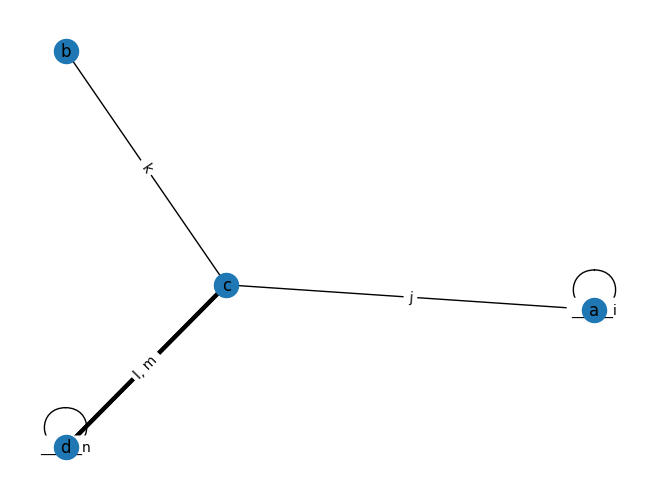

In [2]:
# Here is a network to work with

def construct_graph_from_edges(edges):
    """ Constructs a graph from a list of edges. Every edge is a tuple of the form (node1, node2, size). The tensor at each node is initialized to a random tensor of the corresponding shape. """

    def get_edge_data(graph, node, sort_by=0):
        """ Finds all edges connected to the given node and returns their corresponding data. """
        edges = []
        for n in graph.neighbors(node):
            for e, e_data in graph.get_edge_data(node, n).items():
                edges.append(list(e_data.values()))
        return np.unique(edges, axis=sort_by).T

    graph = nx.MultiGraph()
    for i, edge in enumerate(edges):
        var_label = chr(ord('i') + i)
        graph.add_edge(edge[0], edge[1], var=var_label, size=edge[2])

    for n in list(graph.nodes):
        variables, sizes = get_edge_data(graph, n)
        variables, sizes = list(variables), [int(s) for s in sizes]
        tensor = normalize(np.random.rand(*sizes), p=1, axis=0)
        graph.add_node(n, factor=Factor(variables, tensor))

    return graph

def draw_graph(graph):
    def get_edge_labels(graph):
        edge_labels = {}
        for i, j, d in graph.edges(data=True):
            if (i,j) in edge_labels:
                edge_labels[(i,j)] += f", {d['var']}"
            else:
                edge_labels[(i,j)] = str(d['var'])
        for (i, j), s in edge_labels.items():
            if i == j:
                edge_labels[(i,j)] = "______" + s
        return edge_labels

    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, width=[3**(graph.number_of_edges(i,j)-1) for i, j, d in graph.edges(data=True)])
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=get_edge_labels(graph))

edges = [('a', 'a', 2), ('a', 'c', 2), ('b', 'c', 3), ('c', 'd', 2), ('c', 'd', 3), ('d', 'd', 2)] # each edge corresponds to a variable / index (networkx doesn't support hyperedges)
net = construct_graph_from_edges(edges)
draw_graph(net)
print("Network:", {n :d['factor'].variables for n, d in net.nodes(data=True)})

None

Network: {'A': ['A'], 'AB': ['A', 'B'], 'C': ['C'], 'BCD': ['B', 'C', 'D'], 'DE': ['D', 'E'], 'DF': ['D', 'F']}


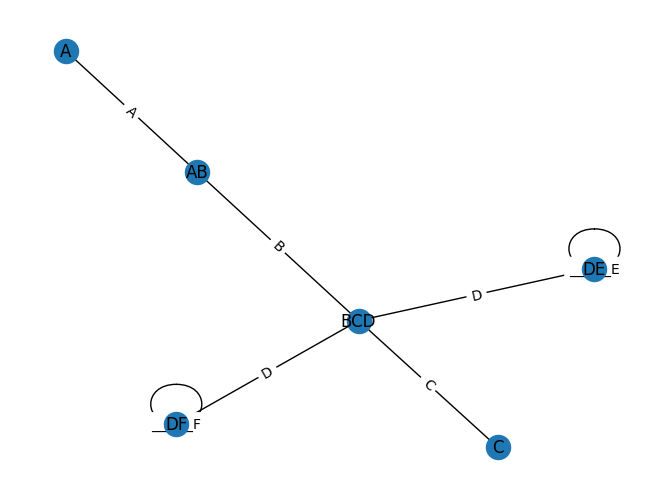

In [3]:
def construct_graph_from_factors(factors: List[Factor]):
    """ Constructs a graph from a list of factors. Every factor is a tuple of the form (variables, tensor). """
    graph = nx.MultiGraph()
    for i, factor in enumerate(factors):
        # node_label = chr(ord('a') + i)
        node_label = ''.join(factor.variables)
        graph.add_node(node_label, factor=factor)

    for i, factor in enumerate(factors):
        # Find the node that contains the factor
        node = None
        for n, d in graph.nodes(data=True):
            if d['factor'] == factor:
                node = n
                break
        if node is None:
                raise Exception("Could not find node for factor:", factor)
        for v in factor.variables:
            for other_factor in factors:
                if v in other_factor.variables and other_factor != factor:
                    # print(f"{''.join(factor.variables)}: Found {v} in {''.join(other_factor.variables)}")
                    # Find the node that contains the other factor
                    other_node = None
                    for n, d in graph.nodes(data=True):
                        if d['factor'] == other_factor:
                            other_node = n
                            break
                    if  other_node is None:
                        raise Exception("Could not find node for factor:", other_factor)
                    # Add an edge between the two nodes if there is not already the opposite edge
                    if not (graph.has_edge(node, other_node) or graph.has_edge(other_node, node)):
                        graph.add_edge(node, other_node, var=v, size=factor.data.shape[factor.variables.index(v)])
            # If there is no other, add a self-loop
            if not any([v in other_factor.variables for other_factor in factors if other_factor != factor]):
                # print(f"{''.join(factor.variables)}: Found {v} in no other factor")
                graph.add_edge(node, node, var=v, size=factor.data.shape[factor.variables.index(v)])

    return graph

# This is the tree in Barber Figure 14.1 and 14.2
net_barber = construct_graph_from_factors([
    Factor('A', np.array([0.01, 0.99])),
    Factor('AB', np.array([[0.1, 0.9], [0.001, 0.999]])),
    Factor('C', np.array([0.001, 0.999])),
    Factor('BCD', np.array([[[0.99, 0.01], [0.9, 0.1]], [[0.95, 0.05], [0.01, 0.99]]])),
    Factor('DE', np.array([[0.9, 0.1], [0.3, 0.7]])),
    Factor('DF', np.array([[0.2, 0.8], [0.1, 0.9]])),
])
# remove edge between 'DE' and 'DF'
net_barber.remove_edge('DE', 'DF')
draw_graph(net_barber)
print("Network:", {n :d['factor'].variables for n, d in net_barber.nodes(data=True)})

In [4]:
# Here is an attempt to add tensors to both nodes and edges
# tree = nx.Graph()

# nodes = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2)]
# edges = [(0, 1), (0, 2), (1, 3), (1, 4), (2, 5)]
# # add a size attribute to each node
# for node, size in nodes:
#     tree.add_node(node, size=size, f=np.random.rand(size))
# # add a tensor to each edge as an attribute with the size of the respective nodes
# for i,j in edges:
#     f = np.random.rand(tree.nodes[i]['size'], tree.nodes[j]['size'])
#     # tensor = normalize(tensor, 1, axis=1)
#     tree.add_edge(i, j, f=f)

# 1. Belief propagation

In [82]:
def belief_prop(graph, query, max_iterations=100, eps=1e-6):
    """
        Computes the marginal distribution of the given query variables using the belief propagation algorithm.    
    
        Parameters
            graph (nx.Graph): The graph for which the marginals should be computed.
            Each node should have the attribute 'factor' containing a Factor object, and each edge should have 
            an attribute 'var' containing the name of the variable present the in factors connected by the edge.

            query (list[str]): A list of variables for which the marginals should be computed

        Returns
            np.ndarray: An array containing the marginals for the given nodes
    """

    # Big table of messages
    messages = {}

    # Initialize messages
    for node in graph.nodes:
        f = graph.nodes[node]['factor']
        for neighbor in graph.neighbors(node):
            # incoming messages to the node
            messages[(neighbor, node)] = Factor(
                potentials=np.ones(f.data.shape),
                variables=f.variables.copy()
            )

    # Iterate until convergence
    for i in range(max_iterations):
        # print("Iteration", i)
        old_messages = messages.copy()
        # Compute messages
        for node in graph.nodes:
            for neighbor in graph.neighbors(node):
                # print(f"Computing message {node} -> {neighbor}")
                # Aggregate messages from other neighbors
                aggregate = Factor()
                for other_neighbor in graph.neighbors(node):
                    if other_neighbor != neighbor:
                        aggregate = aggregate * messages[(other_neighbor, node)]
                # Multiply with the marginal of the node
                total = graph.nodes[node]['factor'] * aggregate
                # Sum out all variables that are not in the neighbor
                for v in total.variables:
                    if v not in graph.nodes[neighbor]['factor'].variables:
                        total = total.marginalize(v)
                # print("total:",total.variables, "neighbor:", graph.nodes[neighbor]['factor'].variables)
                # Normalize the message
                message = total.normalize()
                # print(f"New message {node} -> {neighbor}:", message)
                # Update the message
                if i > 0 and (message.variables != old_messages[(node, neighbor)].variables):
                    print(f"Message variables {message.variables} do not match old message variables {old_messages[(node, neighbor)].variables}")
                messages[(node, neighbor)] = message
        # Check for convergence
        if i == 0:
            continue
        error = 0
        for key in messages:
            error += np.sum(np.abs(messages[key].data - old_messages[key].data))
        # print("Error:", error)
        if error < eps:
            print("Converged after", i, "iterations")
            break

    # Compute marginals for the query variables
    marginal = Factor()
    for node in graph.nodes:
        if any([v in graph.nodes[node]['factor'].variables for v in query]):
            marginal = marginal * graph.nodes[node]['factor']
    for v in marginal.variables:
        if v not in query:
            marginal = marginal.marginalize(v)

    marginal.transpose(query, inplace=True)
    return marginal.normalize()

belief_prop(net, 'ij'), belief_prop(net_barber, 'C')

Converged after 13 iterations
Converged after 8 iterations


(Factor: ['i', 'j'] (2, 2) [[0.39787436 0.34500432]
  [0.07766445 0.17945688]],
 Factor: ['C'] (2,) [0.001 0.999])

# 2. Belief propagation for tensor networks

In [19]:
import quimb as qu
import quimb.tensor as qtn

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [89]:
def tn_mul(t1, t2):
        """ Multiply two tensors element-wise, adding new indices if necessary. New indices are initialized to 1. """
        def add_indices(target, like):
            """ Add all indices of `like` to `target` if they are not already present. """
            for i in reversed(like.inds):
                if i not in target.inds:
                    target.new_ind(i, size=0, axis=-1) # size 0 is a placeholder and will be updated later automatically

        t1 = t1.copy()
        t2 = t2.copy()
        # add all extra indices of t2 to t1 and vice versa
        add_indices(target=t1, like=t2)
        add_indices(target=t2, like=t1)
        # ensure t2 indices have the same order as t1 indices
        t2.transpose(*t1.inds, inplace=True)
        # elementwise multiplication
        return t1 * t2

# Equivalent to `belief_prop` above, but using `quimb.tensor.TensorNetwork` instead of `networkx.Graph`
def belief_prop_tn(tn, query, max_iterations=100, eps=1e-6):
    """ Computes the marginals for given indices in `query`. """
    # Initialize messages
    messages = {}
    for n in tn.tensors:
        # incoming messages to n
        for m in tn.select_neighbors(n.tags):
            messages[(list(n.tags)[0], list(m.tags)[0])] = qtn.Tensor(
                data=np.ones(n.data.shape),
                inds=n.inds,
                tags=n.tags
            )

    # Iterate until convergence
    for i in range(max_iterations):
        # print("Iteration", i)
        old_messages = messages.copy()
        # Compute messages
        for n in tn.tensors:
            for m in tn.select_neighbors(n.tags):
                # print(f"Computing message {n} -> {m}")
                # Aggregate messages from other neighbors
                aggregate = qtn.Tensor(data=1, inds=[], tags=[])
                for other_neighbor in tn.select_neighbors(n.tags):
                    if other_neighbor != m:
                        aggregate = tn_mul(aggregate, messages[(list(other_neighbor.tags)[0], list(n.tags)[0])])
                # Multiply with the marginal of the node
                total = tn_mul(n, aggregate)
                # Sum out all variables that are not in the neighbor
                for v in total.inds:
                    if v not in m.inds:
                        total = total.sum_reduce(v)
                # print("total:",total.inds, "neighbor:", tn[m].inds)
                # Normalize the message
                message = total / total.data.sum()
                # print(f"New message {n} -> {m}:", message)
                # Update the message
                if i > 0 and (message.inds != old_messages[(list(n.tags)[0], list(m.tags)[0])].inds):
                    print(f"Message indices {message.inds} do not match old message indices {old_messages[(n.tags, m.tags)].inds}")
                messages[(list(n.tags)[0], list(m.tags)[0])] = message
        # Check for convergence
        if i == 0:
            continue
        error = 0
        for key in messages:
            error += np.sum(np.abs(messages[key].data - old_messages[key].data))
        # print("Error:", error)
        if error < eps:
            print("Converged after", i, "iterations")
            break

    # Compute marginals for the query variables
    marginal = qtn.Tensor(data=1, inds=[], tags=[])
    for n in tn.tensors:
        if any([v in n.inds for v in query]):
            marginal = tn_mul(marginal, n)
    for v in marginal.inds:
        if v not in query:
            marginal = marginal.sum_reduce(v)

    marginal.transpose(*query, inplace=True)
    return marginal / marginal.data.sum()

def get_tn(graph):
    """ Returns a tensor network from the given graph. """
    T = qtn.TensorNetwork()
    for n, n_data in graph.nodes(data=True):
        tensor = qtn.Tensor(n_data['factor'].data, inds=n_data['factor'].variables, tags=n)
        T |= tensor
    return T

In [90]:
# Define a tensor network from the graph `net`
T = get_tn(net)
# T.draw()
query = 'ij'

assert np.allclose(belief_prop(net, query).data, belief_prop_tn(T, query).data)

belief_prop_tn(T, query)

Converged after 13 iterations
Converged after 2 iterations
Converged after 2 iterations


Tensor(shape=(2, 2), inds=('i', 'j'), tags=oset(['a', 'c']))

In [91]:
T_barber = get_tn(net_barber)
query = 'C'
assert np.allclose(belief_prop(net_barber, query).data, belief_prop_tn(T_barber, query).data)
belief_prop_tn(T_barber, query)

Converged after 8 iterations
Converged after 8 iterations
Converged after 8 iterations


Tensor(shape=(2,), inds=('C',), tags=oset(['C', 'BCD']))

In [53]:
t1 = qtn.Tensor(np.random.rand(2, 3, 4), inds='abc', tags='t1')
t2 = qtn.Tensor(np.random.rand(3, 4, 5), inds='bcd', tags='t2')
tn = t1 | t2
list(t1.tags)[0]

't1'